# Tweets NLP challenge

Using tweets from [kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score,RepeatedKFold,cross_validate
import statsmodels.stats.api as sms
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix,roc_curve, auc,f1_score,recall_score,precision_score,roc_auc_score
from scipy import interp
from itertools import cycle

from sklearn import __version__ as skv
from xgboost import __version__ as xgbv
from nltk import __version__ as nltkv

In [2]:
print("Numpy Version:",np.__version__)
print("pandas Version:",pd.__version__)
print("sklearn Version:",skv)
print("NLTK Version:",nltkv)
print("xgboost Version:",xgbv)

Numpy Version: 1.19.4
pandas Version: 1.1.4
sklearn Version: 0.23.2
NLTK Version: 3.5
xgboost Version: 1.3.3


In [3]:
data=pd.read_csv("Tweets.csv")

## 1. Data Exploration

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
data.isna().sum()/len(data)*100

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

In [6]:
data.drop(columns=["negativereason_gold","airline_sentiment_gold","tweet_coord"],inplace=True)

In [7]:
data.duplicated().sum()

39

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data.describe(include="object")

,airline_sentiment,negativereason,airline,name,text,tweet_created,tweet_location,user_timezone
count,14601,9157,14601,14601,14601,14601,9879,9789
unique,3,10,6,7701,14427,14247,3081,85
top,negative,Customer Service Issue,United,JetBlueNews,@united thanks,2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9157,2902,3822,63,6,5,157,3738


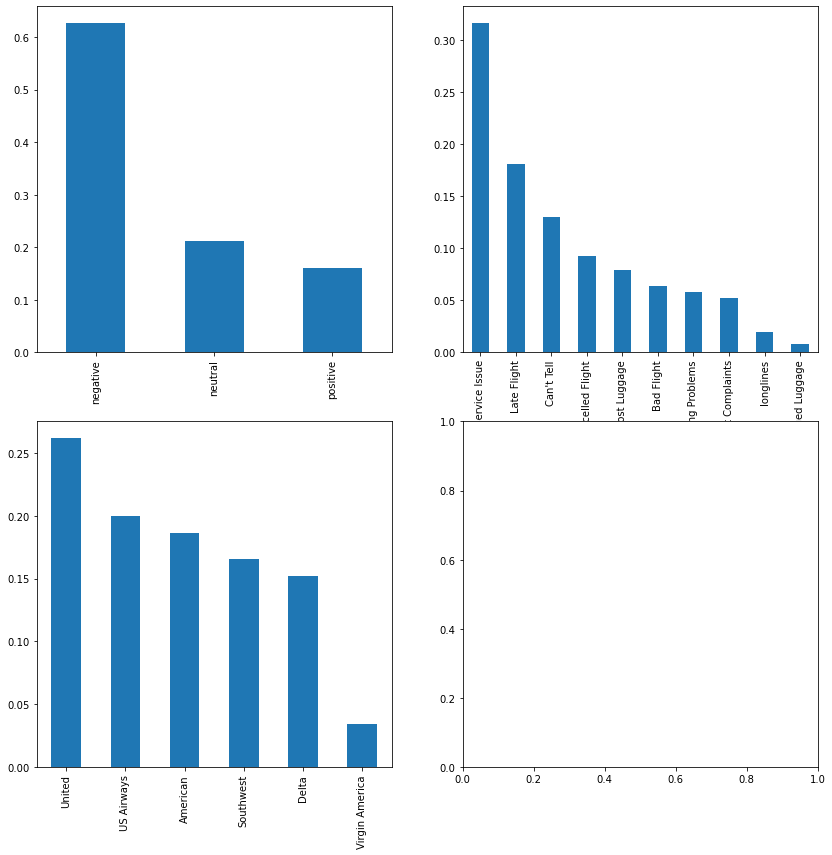

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
for idx,column in enumerate(data[["airline_sentiment","negativereason","airline"]]):
    data[column].value_counts(normalize=True).plot(ax=axs[idx//2,idx%2],kind="bar")

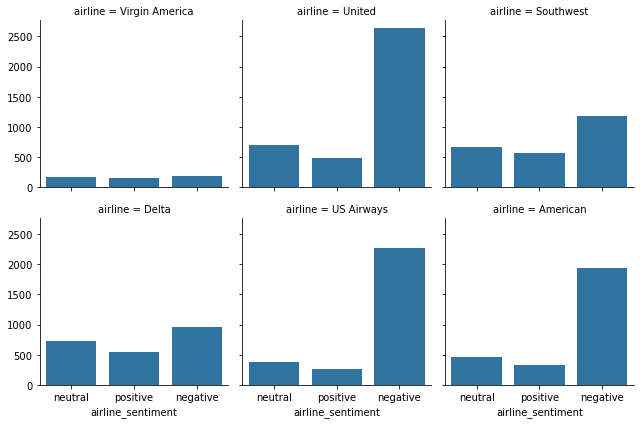

In [11]:
g = sns.FacetGrid(data, col="airline",col_wrap=3)
g.map(sns.countplot, "airline_sentiment",order=list(data["airline_sentiment"].unique()));#order to remove warning

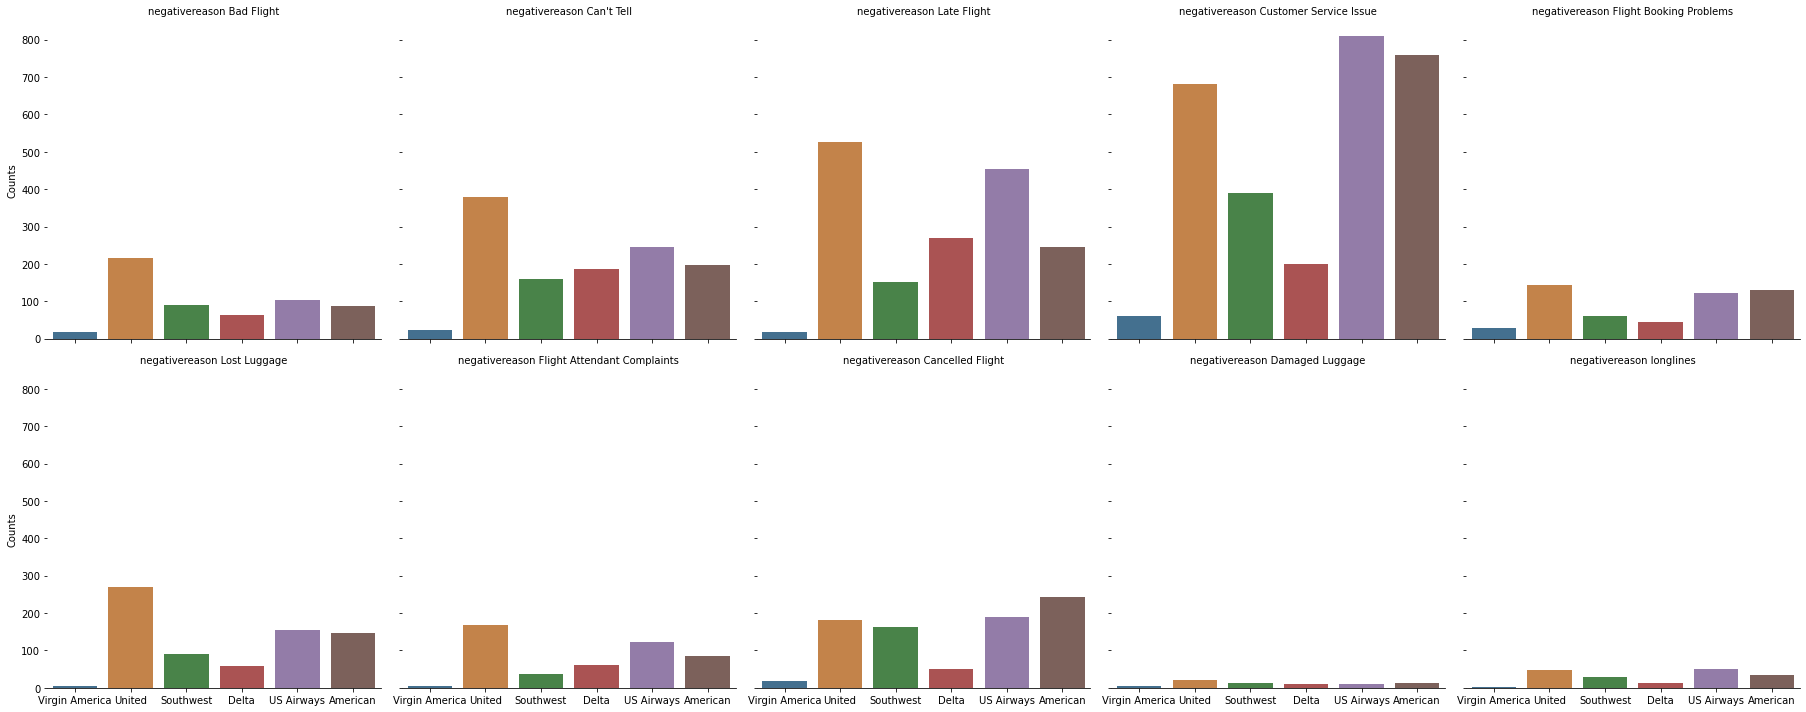

In [12]:
g = sns.catplot(x="airline", col="negativereason",
                data=data, saturation=.5,
                kind="count",col_wrap=5)
(g.set_axis_labels("", "Counts")
  .set_xticklabels(list(data["airline"].unique()))
  .set_titles("{col_var} {col_name}")
  .despine(left=True)) ;

In [13]:
negative = " ".join(tweet.lower() for tweet in data[data["airline_sentiment"]=="negative"]["text"])
airlines=list(map(str.lower,list(data["airline"].unique())))
airlines.extend([x.replace(" ","") for x in airlines]) 
positive=" ".join(tweet.lower() for tweet in data[data["airline_sentiment"]=="positive"]["text"])
neutral=" ".join(tweet.lower() for tweet in data[data["airline_sentiment"]=="neutral"]["text"])
stopwords = set(STOPWORDS)
stopwords.update(airlines)

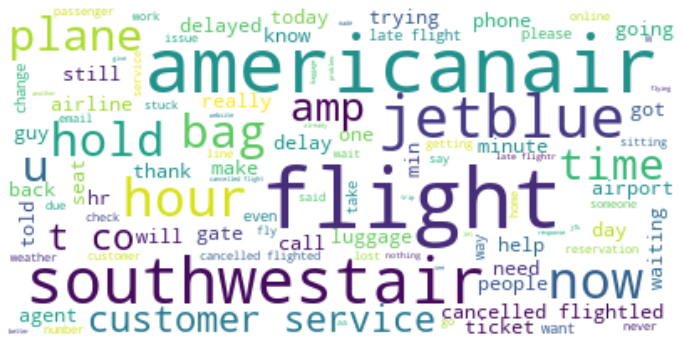

In [14]:
plt.figure(1,figsize=(12, 12))
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=100, background_color="white").generate(negative)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

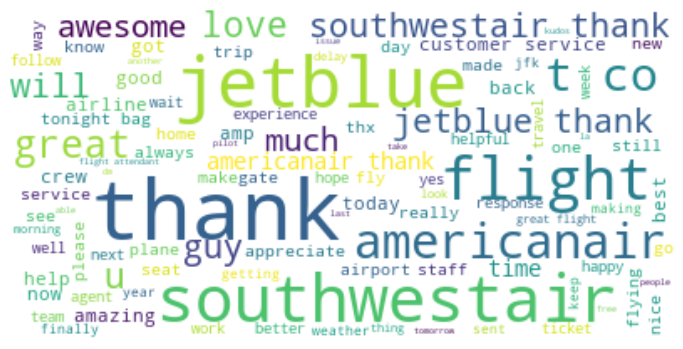

In [15]:
plt.figure(1,figsize=(12, 12))
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=100, background_color="white").generate(positive)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

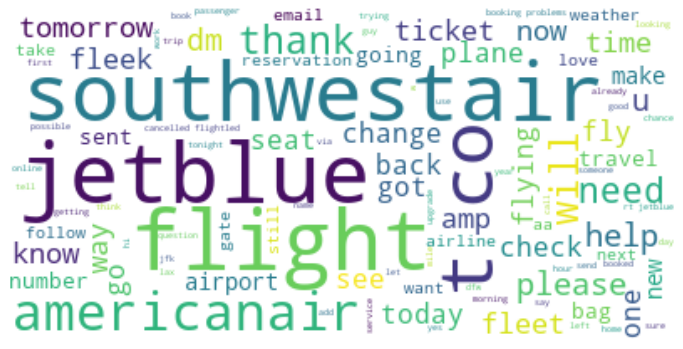

In [16]:
plt.figure(1,figsize=(12, 12))
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=100, background_color="white").generate(neutral)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2. Text Representation

In [17]:
train,test=train_test_split(data,test_size=0.2,stratify=data["airline_sentiment"],random_state=2)

In [18]:
display(train["airline_sentiment"].value_counts())
display(test["airline_sentiment"].value_counts())

negative    7325
neutral     2473
positive    1882
Name: airline_sentiment, dtype: int64

negative    1832
neutral      618
positive     471
Name: airline_sentiment, dtype: int64

In [19]:
vectorizer= CountVectorizer(tokenizer=TweetTokenizer().tokenize)
vectorizer.fit(train["text"])
train_features = vectorizer.transform(train["text"])
test_features  = vectorizer.transform(test["text"])

/home/john/.conda/envs/py3-wsl/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [20]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(train_features)
X_test_tfidf= tfidf_transformer.transform(test_features)

In [21]:
normalizer = Normalizer().fit(X_train_tfidf) 
x_normalized=normalizer.transform(X_train_tfidf)
x_test_normalized=normalizer.transform(X_test_tfidf)

### 3. Model Creation

In [22]:
rcv = RepeatedKFold(n_splits=10, random_state=70,n_repeats=3)

In [23]:
dense=x_normalized.toarray()

In [24]:
#baseline 
nb=GaussianNB()
scores = cross_validate(nb, dense, train['airline_sentiment'], scoring=['accuracy',"precision_weighted","recall_weighted","roc_auc_ovo_weighted","f1_weighted"], cv=rcv, n_jobs=1)
print("accuracy",sms.DescrStatsW(scores["test_accuracy"]).tconfint_mean())
print("precision",sms.DescrStatsW(scores["test_precision_weighted"]).tconfint_mean())
print("recall",sms.DescrStatsW(scores["test_recall_weighted"]).tconfint_mean())
print("roc_auc_ovo",sms.DescrStatsW(scores["test_roc_auc_ovo_weighted"]).tconfint_mean())
print("f1",sms.DescrStatsW(scores["test_f1_weighted"]).tconfint_mean())

accuracy (0.5204174365641013, 0.5296967186870399)
precision (0.6053846748879118, 0.6147959648106912)
recall (0.5204174365641013, 0.5296967186870399)
roc_auc_ovo (0.6273949488493691, 0.6343909955408726)
f1 (0.5436958383879062, 0.5522659776742467)


In [25]:
Classifiers = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(3),
    SVC(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    ]

In [26]:
accuracy_l=[]
for classifier in Classifiers:
    print(classifier.__class__.__name__)
    try:
        scores = cross_validate(classifier, x_normalized, train['airline_sentiment'], scoring=['accuracy',"precision_weighted","recall_weighted","roc_auc_ovo_weighted","f1_weighted"], cv=rcv, n_jobs=-2)
        accuracy_l.append(scores)
    except:
        scores = cross_validate(classifier, x_normalized, train['airline_sentiment'], scoring=['accuracy',"precision_weighted","recall_weighted","f1_weighted"], cv=rcv, n_jobs=-2)
        accuracy_l.append(scores)

LogisticRegression
KNeighborsClassifier
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier


In [27]:
for idx,element in enumerate(accuracy_l):
    print(Classifiers[idx].__class__.__name__,"accuracy",sms.DescrStatsW(element["test_accuracy"]).tconfint_mean())
    print(Classifiers[idx].__class__.__name__,"precision",sms.DescrStatsW(element["test_precision_weighted"]).tconfint_mean())
    print(Classifiers[idx].__class__.__name__,"recall",sms.DescrStatsW(element["test_recall_weighted"]).tconfint_mean())
    try:
        print(Classifiers[idx].__class__.__name__,"roc_auc_ovo",sms.DescrStatsW(element["test_roc_auc_ovo_weighted"]).tconfint_mean())
    except KeyError:
        print(Classifiers[idx].__class__.__name__,"roc_auc_ovo",None)

    print(Classifiers[idx].__class__.__name__,"f1",sms.DescrStatsW(element["test_f1_weighted"]).tconfint_mean())
    print(Classifiers[idx].__class__.__name__,"fit_time",sms.DescrStatsW(element["fit_time"]).tconfint_mean())
    print("---"*40)

LogisticRegression accuracy (0.8020082538017419, 0.8102063580704044)
LogisticRegression precision (0.7964474849493679, 0.805210190521267)
LogisticRegression recall (0.8020082538017419, 0.8102063580704044)
LogisticRegression roc_auc_ovo (0.9089798165846615, 0.9141508322137971)
LogisticRegression f1 (0.7907045687477428, 0.7998021302841065)
LogisticRegression fit_time (2.6575932283930674, 2.9314233839777417)
------------------------------------------------------------------------------------------------------------------------
KNeighborsClassifier accuracy (0.7114542851994653, 0.7213082718781606)
KNeighborsClassifier precision (0.7045423687952818, 0.7150506466281746)
KNeighborsClassifier recall (0.7114542851994653, 0.7213082718781606)
KNeighborsClassifier roc_auc_ovo (0.7940710408809487, 0.8008289659030795)
KNeighborsClassifier f1 (0.7068045028266917, 0.7169514364160107)
KNeighborsClassifier fit_time (0.02414307896011493, 0.03283536927190004)
----------------------------------------------

In [28]:
clf = XGBClassifier(random_state=42, seed=2)
scores = cross_validate(clf, x_normalized, train['airline_sentiment'], scoring=['accuracy',"precision_weighted","recall_weighted","roc_auc_ovo_weighted","f1_weighted"], cv=rcv, n_jobs=-2)
print("accuracy",sms.DescrStatsW(scores["test_accuracy"]).tconfint_mean())
print("precision",sms.DescrStatsW(scores["test_precision_weighted"]).tconfint_mean())
print("recall",sms.DescrStatsW(scores["test_recall_weighted"]).tconfint_mean())
print("roc_auc_ovo",sms.DescrStatsW(scores["test_roc_auc_ovo_weighted"]).tconfint_mean())
print("f1",sms.DescrStatsW(scores["test_f1_weighted"]).tconfint_mean())

accuracy (0.7863348507807085, 0.7921468843791085)
precision (0.7780285351413841, 0.7842668731456425)
recall (0.7863348507807085, 0.7921468843791085)
roc_auc_ovo (0.8972401174475872, 0.9016034219295863)
f1 (0.7763780452004976, 0.7825661775961719)


## 4. Test assessment

In [29]:
lg=LogisticRegression(random_state=42)
model = lg.fit( x_normalized, train['airline_sentiment']);
pred=model.predict(x_test_normalized);
pred_proba=model.predict_proba(x_test_normalized);
cmatrix=confusion_matrix(pred , test['airline_sentiment']);
print(classification_report(pred,test["airline_sentiment"]))

              precision    recall  f1-score   support

    negative       0.94      0.82      0.88      2089
     neutral       0.52      0.70      0.60       459
    positive       0.65      0.82      0.72       373

    accuracy                           0.80      2921
   macro avg       0.70      0.78      0.73      2921
weighted avg       0.84      0.80      0.81      2921



/home/john/.conda/envs/py3-wsl/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [30]:
print(accuracy_score(pred,test["airline_sentiment"]))
print(precision_score(pred,test["airline_sentiment"],average="weighted"))
print(recall_score(pred,test["airline_sentiment"],average="weighted"))
print(f1_score(pred,test["airline_sentiment"],average="weighted"))

0.8045190003423485
0.8371634595891767
0.8045190003423485
0.8147721209665493


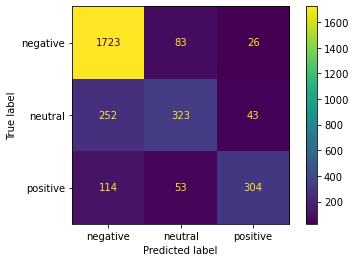

In [31]:
plot_confusion_matrix(lg, x_test_normalized, test['airline_sentiment']) 
plt.show()

In [32]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=np.array(test['airline_sentiment']), predict_vector=np.array(pred)) # Create CM From Data
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.86968
F1 Macro                                                          0.73302
FPR Macro                                                         0.1411
Kappa                                                             0.60717
Overall ACC                                                       0.80452
PPV Macro                                                         0.78117
SOA1(Landis & Koch)                                               Substantial
TPR Macro                                                         0.70286
Zero-one Loss                                                     571

Class Statistics :

Classes                                                           negative      neutral       positive      
ACC(Accuracy)                                                     0.83738       0.85245       0.91921       
AUC(Area under the ROC curve)                                     0.80221

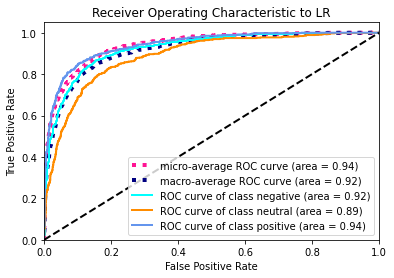

In [39]:
# Compute ROC curve and ROC area for each class
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=3
y_test=np.array(pd.get_dummies(test["airline_sentiment"]))# 0 negative, 1 neutral, 2 positive
labels_ml=["negative","neutral","positive"]
y_score=pred_proba
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels_ml[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to LR')
plt.legend(loc="lower right")
plt.show()